# Comparing GRU and LSTM with Stock data

In [1]:
#!pip install yfinance

import sys
print(sys.executable)

# numpy 설치했음에도 에러가 날때
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\lib\\site-packages')
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow')
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\lib')       
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\DLLs')        
sys.path.append('C:\\Users\\ample\\miniconda3\\envs\\tensorflow\\python37.zip')


import numpy as np
import pandas as pd 


import yfinance as yf # Yahoo finance 에서 제공하는 데이터에 접근 가능

C:\Users\ample\miniconda3\python.exe


## 1. 주식가격 데이터 불러오기   
    * train data: 2013년부너 2018년까지의 일일 주가
    * test data : 2019년의 일일 주가

There are 1511 observations in the training data
There are 251 observations in the test data
(1511, 6)
<class 'pandas.core.frame.DataFrame'>


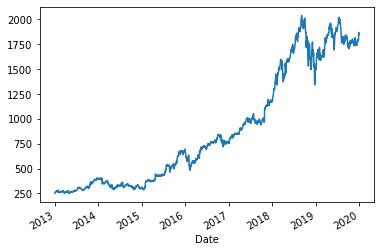

In [2]:
# 아마존의 2013년 부터 2018년까지 일일 주가를 학습 데이터로
# 2019년 데이터를 테스트 데이터로 사용 

AMZN = yf.download('AMZN', 
                  start = '2013-01-01',
                  end = '2019-12-31',
                  progress = False)


# 수정종가(Adj close), 시가(Open), 최고가(High), 최저가(Low), 종가(Close). 거래량(Volume)
all_data = AMZN[['Adj Close', 'Open', 'High','Low',"Close","Volume"]].round(2)

all_data.head(15)

print("There are "+str(all_data[:'2018'].shape[0])+" observations in the training data")
print("There are "+str(all_data['2019':].shape[0])+" observations in the test data")

print(all_data[:'2018'].shape)

all_data['Adj Close'].plot()

print(type(all_data))

In [3]:
all_data.head(5)

,Adj Close,Open,High,Low,Close,Volume
Date,,,,,,
2012-12-31,250.87,243.75,252.41,242.75,250.87,3419000
2013-01-02,257.31,256.08,258.10,253.26,257.31,3271000
2013-01-03,258.48,257.27,260.88,256.37,258.48,2750900
2013-01-04,259.15,257.58,259.80,256.65,259.15,1874200
2013-01-07,268.46,262.97,269.73,262.67,268.46,4910000


## 2. RNN/LSTM을 위한 학습데이터 만들기
단변량 주식 가격 시계열로 부터 학습데이터를 생성
    * MANY 2 MANY
    * MANY 2 ONE

### 2-1. MANY 2 MANY
- 과거 X일의 가격을 사용해서 미래 Y일의 가격을 예측
- 빨간색 창을 시리즈에 따라 움직여서 __샘플__ 을 만듦
- 각 샘플은 5가지 입력값과 2개의 출력값을 가짐
- __타임스텝__ : 각 샘플의 입력값
- __feature__ : 매 타임스텝마다 feature라고 불리는 하나의 숫자를 가짐. feature의 수는 여러개일 수 있음
--------------------
![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FbJf0aY%2FbtqUL9JDeyT%2Fp0MlEeFIYl7SkbRCkDwkW0%2Fimg.png)

### 2-2. MANY 2 ONE
- 출력값 하나
----------------
![IMAGE](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FrTfhY%2FbtqVRwhXa0G%2FRxW8kzcRHT2HbXRZlKP2QK%2Fimg.png)

X가 다차원인 변수를 LSTM 입력을 위해 3차원으로 변형   
![image](https://1.bp.blogspot.com/-As5cOG_Fatc/XMR80nemvGI/AAAAAAAAqds/_xQakPgc0uoXMXPDv9pB9-AJxdjsuDWNACLcBGAs/s640/nn.png)    

-------
![image](https://4.bp.blogspot.com/-duOcCEd9DJU/XMSJD6kzDJI/AAAAAAAAqd4/xlbs2_fbw248QJGkahI5IJJeOHEMBJKdwCLcBGAs/s400/nn2.png)

### 2-3. RNN/LSTM/GRU는 3차원의 배열을 입력
- __Tensor__ : 하나의 텐서는 모델에 들어가는 벡터임
- __Time Step__ : 하나의 타임스텝은 텐서에서 하나의 관측치
- __Feature__ : 한 feature는 그 타임스텝에서 하나의 관측치 

따라서 위의 1차원 배열은 3차원 배열로 변경되어야 함   
--> [# of samples, # of time steps, # of features]    




np.reshape(samples, time steps, features) 로 만듦

## 3. RNN/LSTM/GRU 에 정규화된 데이터 필요함
- 학습 데이터만 스케일 변환에 사용됨(scaler transformation)
- train_x 와 test_x를 독립적으로 스케일링하지 말 것!

In [4]:
def ts_train_test_normalize(all_data, time_steps, for_periods):
    """
    input: 
        data: dataframe with dates and price data
    output: 
        X_train, y_train: data from 2013/1/1-2018/12/31 
        X_test : data from 2019- 
        sc :     insantiated MinMaxScaler object fit to the training data 
    """
    # create training and test set 
    ts_train = all_data[:'2018'].iloc[:,0:1].values # 여기서 종가만 컷 # 콤마가 차원구분, n:m n 부터 m인덱스미만까지
    print(type(ts_train)) # ndarray
    print(ts_train[:5]) # head 대체 # 종가 [[250.87] [257.31]]
    
    
    ts_test = all_data['2019':].iloc[:,0:1].values 
    ts_train_len = len(ts_train)
    ts_test_len = len(ts_test)
    
    # scale the data 
    from sklearn.preprocessing import MinMaxScaler 
    sc = MinMaxScaler(feature_range=(0,1))
    ts_train_scaled = sc.fit_transform(ts_train) # fit 은 표준편차 구하는거고, transform 은 구한걸로 변환 # train 데이터로 fit해서 test를 변환
    
    # create training data of s samples and t time steps 
    X_train = [] 
    y_train = [] 
    for i in range(time_steps, ts_train_len-1):  # 종가를 타임스텝5로 잘라 배열하는듯. range(n, m) n 부터 m까지
        X_train.append(ts_train_scaled[i-time_steps:i, 0]) # 종가 5개
        y_train.append(ts_train_scaled[i:i+for_periods, 0]) # 결과 2개 
    X_train, y_train = np.array(X_train), np.array(y_train)
    
    print(type(X_train)) # ndarray
    print(X_train[:5])
    print(X_train.shape) # (1505, 5)
    
    print('=============');    
    print('=============');

    
    # Reshaping X_train for efficient modelling # 3차원으로
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1 ))
    
    print(X_train.shape) # (1505, 5, 1)

    inputs = pd.concat((all_data["Adj Close"][:'2018'], all_data["Adj Close"]['2019':]), axis=0).values
    print(type(inputs))  # ndarray
    print(inputs.shape) # (1762,) # train + test
    
    inputs = inputs[len(inputs)-len(ts_test)-time_steps:]
    
    print(inputs.shape) # (256,)
    
    inputs = inputs.reshape(-1,1)
    
    print(inputs.shape) # (256, 1)
    print('=============');
    inputs = sc.transform(inputs) # 테스트 데이터 정규화  #위에서 train 데이터로 fit한걸로 test를 변환
    
    # Preparing X_test 
    X_test = [] 
    for i in range(time_steps, ts_test_len + time_steps - for_periods):
        X_test.append(inputs[i-time_steps:i,0])
    
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, y_train , X_test, sc 

In [5]:
X_train, y_train, X_test, sc = ts_train_test_normalize(all_data, 5,2)

print('X_train.shape: ' + ", ".join(map(str,X_train.shape))) # (1505, 5, 1)
print('y_train.shape: ' + ", ".join(map(str,y_train.shape))) # (1505, 2)


<class 'numpy.ndarray'>
[[250.87]
 [257.31]
 [258.48]
 [259.15]
 [268.46]]
<class 'numpy.ndarray'>
[[0.00147381 0.005069   0.00572217 0.0060962  0.0112936 ]
 [0.005069   0.00572217 0.0060962  0.0112936  0.01013242]
 [0.00572217 0.0060962  0.0112936  0.01013242 0.01011567]
 [0.0060962  0.0112936  0.01013242 0.01011567 0.00955183]
 [0.0112936  0.01013242 0.01011567 0.00955183 0.0110033 ]]
(1505, 5)
(1505, 5, 1)
<class 'numpy.ndarray'>
(1762,)
(256,)
(256, 1)
X_train.shape: 1505, 5, 1
y_train.shape: 1505, 2


In [6]:
# Convert the 3D shape of X_train to a data frame so we can see: 
X_train_see = pd.DataFrame(np.reshape(X_train, (X_train.shape[0], X_train.shape[1])))
print(X_train_see.shape) # (1505, 5)
y_train_see = pd.DataFrame(y_train)
print(y_train.shape) # (1505, 2)

pd.concat([X_train_see, y_train_see], axis = 1) # 이걸 왜한거임? 리턴값이 합쳐진 배열인데 받지도 않을거?

print(X_train_see.shape) # (1505, 5) 그대로다

# Convert the 3D shape of X_test to a data frame so we can see: 
X_test_see = pd.DataFrame(np.reshape(X_test, (X_test.shape[0], X_test.shape[1])))
pd.DataFrame(X_test_see)

print("There are " + str(X_train.shape[0]) + " samples in the training data")
print("There are " + str(X_test.shape[0]) + " samples in the test data")

(1505, 5)
(1505, 2)
(1505, 5)
There are 1505 samples in the training data
There are 249 samples in the test data


![image](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FYg4ZQ%2Fbtq01rdsR9T%2F9LzqQhxjAqzrilam8PyXY1%2Fimg.png)

## 4. LSTM 모델

In [7]:
def LSTM_model(X_train, y_train, X_test, sc):
    # create a model
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU, LSTM
    from tensorflow.keras.optimizers import SGD
    
    print('######')
    print(X_train.shape)
    
    # The LSTM architecture
    my_LSTM_model = Sequential()
    my_LSTM_model.add(LSTM(units = 50, 
                           return_sequences = True, 
                           input_shape = (X_train.shape[1],1), 
                           activation = 'tanh'))
    my_LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
    my_LSTM_model.add(Dense(units=2))
    
    # Compiling 
    my_LSTM_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False),
                         loss = 'mean_squared_error')
    
    # Fitting to the training set 
    my_LSTM_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    LSTM_prediction = my_LSTM_model.predict(X_test)
    LSTM_prediction = sc.inverse_transform(LSTM_prediction)
    
    
    return my_LSTM_model, LSTM_prediction 

momentom - nesterov

-----
![image](https://github.com/skywalker023/blog_images/blob/master/optimization/nesterov_momentum.png?raw=true)

In [8]:
def actual_pred_plot(preds):
    """
    Plot the actual vs predition
    # preds 엔 2 period 예측치 넘어오지만 오차 그릴땐 한줄만 뽑아서 비교함
    """
    print('=================')
    print('preds: ' + ", ".join(map(str,preds.shape))) 
    print(preds[:10, ])
    
    
    # 0칼럼: 실제  , 1칼럼: 예측
    actual_pred = pd.DataFrame(columns = ['Adj. Close', 'prediction'])
    actual_pred['Adj. Close'] = all_data.loc['2019':,'Adj Close'][0:len(preds)] # 실제
    actual_pred['prediction'] = preds[:,0] # 예측
    
    print('=================')
    print(actual_pred[:10])
    
    print('actual_pred: ' + ", ".join(map(str,actual_pred.shape))) # (249, 2) (테스트 행 갯수, 실제+예측치)
        
    from keras.metrics import MeanSquaredError 
    m = MeanSquaredError()
    m.update_state(np.array(actual_pred['Adj. Close']), np.array(actual_pred['prediction']))
    
    return (m.result().numpy(), actual_pred.plot())

######
(1505, 5, 1)


C:\Users\ample\miniconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:106: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 0s 2ms/step
*************
[[[0.61170225]
  [0.68256777]
  [0.67739829]
  [0.68654258]
  [0.69991291]]

 [[0.68256777]
  [0.67739829]
  [0.68654258]
  [0.69991291]
  [0.72065785]]

 [[0.67739829]
  [0.68654258]
  [0.69991291]
  [0.72065785]
  [0.69896945]]

 [[0.68654258]
  [0.69991291]
  [0.72065785]
  [0.69896945]
  [0.74090036]]

 [[0.69991291]
  [0.72065785]
  [0.69896945]
  [0.74090036]
  [0.77111339]]]
preds: 249, 2
[[1455.6843 1458.8633]
 [1493.5581 1497.1343]
 [1502.1553 1505.6422]
 [1519.8324 1523.3854]
 [1543.0845 1546.7454]
 [1569.2041 1572.9142]
 [1592.3665 1595.8337]
 [1625.7126 1629.2844]
 [1641.6058 1645.4528]
 [1642.8304 1646.6974]]
            Adj. Close   prediction
Date                               
2019-01-02     1539.13  1455.684326
2019-01-03     1500.28  1493.558105
2019-01-04     1575.39  1502.155273
2019-01-07     1629.51  1519.832397
2019-01-08     1656.58  1543.084473
2019-01-09     1659.42  1569.204102
2019-01-10     16

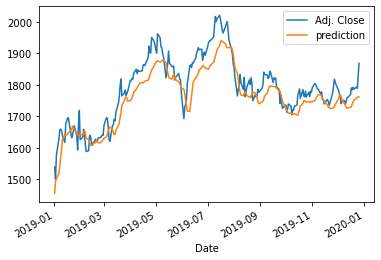

In [10]:
my_LSTM_model, LSTM_prediction = LSTM_model(X_train, y_train, X_test, sc)
#LSTM_prediction[1:10]

print('*************')
print(X_test[0:5])


actual_pred_plot(LSTM_prediction) # 그냥 그래프 그리고 끝

print('=================')
print('LSTM_prediction: ' + ", ".join(map(str,LSTM_prediction.shape)))
print(LSTM_prediction[0:10]) # 5개 먹이고, 2개의 출력값 예측


In [10]:
y_pred = pd.DataFrame(LSTM_prediction[:, 0]) # 2개 예측치 중에 하나만 사용함. 이럴거면 왜 2개 출력함?
print(y_pred)

y_test=all_data.loc['2019':,'Adj Close'][0:len(LSTM_prediction)]

print(y_test) # 연도가 나오지만, 종가로만 구성된 1칼럼
print(type(y_test)) # <class 'pandas.core.series.Series'>

y_test.reset_index(drop=True, inplace=True) # 날짜 인덱스를 기본 숫자인덱스로 리셋

print(y_test)

# 이 시점에서: y_pred, y_test 차원 똑같음


               0
0    1456.901855
1    1496.302490
2    1505.269775
3    1523.197021
4    1546.773438
..           ...
244  1756.545410
245  1762.183472
246  1768.227783
247  1772.872681
248  1772.632812

[249 rows x 1 columns]
Date
2019-01-02    1539.13
2019-01-03    1500.28
2019-01-04    1575.39
2019-01-07    1629.51
2019-01-08    1656.58
               ...   
2019-12-19    1792.28
2019-12-20    1786.50
2019-12-23    1793.00
2019-12-24    1789.21
2019-12-26    1868.77
Name: Adj Close, Length: 249, dtype: float64
<class 'pandas.core.series.Series'>
0      1539.13
1      1500.28
2      1575.39
3      1629.51
4      1656.58
        ...   
244    1792.28
245    1786.50
246    1793.00
247    1789.21
248    1868.77
Name: Adj Close, Length: 249, dtype: float64


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, r2_score

def confirm_result(y_test, y_pred):
    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    MSLE = mean_squared_log_error(y_test, y_pred)
    RMSLE = np.sqrt(mean_squared_log_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)
    
    pd.options.display.float_format = '{:.5f}'.format
    Result = pd.DataFrame(data=[MAE,RMSE, RMSLE, R2],
                         index = ['MAE','RMSE', 'RMSLE', 'R2'],
                         columns=['Results'])
    return Result

In [13]:
confirm_result(y_test, y_pred)

,Results
MAE,43.16761
RMSE,52.81748
RMSLE,0.02934
R2,0.72897


## 5. GRU 모델
- LSTM 과의 차이점 : cell state와 output gate 가 없음 --> LSTM 보다 파라미터가 적음

In [13]:
def GRU_model(X_train, y_train, X_test, sc):
    # create a model 
    from tensorflow.keras.models import Sequential 
    from tensorflow.keras.layers import Dense, SimpleRNN, GRU
    from tensorflow.keras.optimizers import SGD 
    
    # The GRU architecture 
    my_GRU_model = Sequential()
    my_GRU_model.add(GRU(units = 50, 
                         return_sequences = True, 
                         input_shape = (X_train.shape[1],1), 
                         activation = 'tanh'))
    my_GRU_model.add(GRU(units = 50, 
                         activation = 'tanh'))
    my_GRU_model.add(Dense(units = 2))
    
    # Compiling the RNN 
    my_GRU_model.compile(optimizer = SGD(lr = 0.01, decay = 1e-7, 
                                         momentum = 0.9, nesterov = False), 
                         loss = 'mean_squared_error')
    
    # Fitting to the trainig set 
    my_GRU_model.fit(X_train, y_train, epochs = 50, batch_size = 150, verbose = 0)
    
    GRU_prediction = my_GRU_model.predict(X_test)
    GRU_prediction = sc.inverse_transform(GRU_prediction)
    
    return my_GRU_model, GRU_prediction 

C:\Users\ample\miniconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:106: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


8/8 [==============================] - 0s 2ms/step


(1135.2618, <AxesSubplot:xlabel='Date'>)

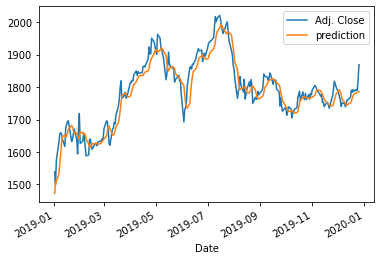

In [14]:
my_GRU_model, GRU_prediction = GRU_model(X_train, y_train, X_test, sc)
GRU_prediction[1:10]
actual_pred_plot(GRU_prediction)

In [15]:
y_pred_gru = pd.DataFrame(GRU_prediction[:, 0])
y_test_gru=all_data.loc['2019':,'Adj Close'][0:len(GRU_prediction)]
y_test_gru.reset_index(drop=True, inplace=True)

In [16]:
confirm_result(y_test_gru, y_pred_gru)

,Results
MAE,25.92415
RMSE,33.69364
RMSLE,0.01907
R2,0.88971
